# 딥러닝 모형 실습

### 라이브러리 선언

일반 CPU 활용 시

In [1]:
# # 라이브러리 정의 
# from tensorflow import keras
# from tensorflow.keras import layers
# import numpy as np
# import pandas as pd

cuda nvidia gpu 활용 시

In [2]:
# How to check if the code is running on GPU or CPU?

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13598731493470210294
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1426250139
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11223400197388885340
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


intel gpu 활용 시

In [3]:
# import numpy as np
# import os

# # intel gpu 적용
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
# import keras
# # mnist 데이터셋 
# from keras.datasets import mnist


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

# 1. 데이터 불러오기 및 컬럼 생성

In [5]:
# 데이터 불러오기 및 정렬
featuresData = pd.read_csv("../dataset/feature_regression_example.csv")
sortKey = ["REGIONID","PRODUCTGROUP","PRODUCT","ITEM","YEARWEEK"]
featuresData = featuresData.sort_values(sortKey)

In [6]:
# 숫자형 컬럼 생성
from sklearn.preprocessing import LabelEncoder
le_yn = LabelEncoder()

featuresData["LE_PROMO"] = \
        le_yn.fit_transform(featuresData.PROMOTION)
featuresData["LE_HOLI"] = \
    le_yn.fit_transform(featuresData.HOLIDAY)

# 2. 데이터 분리

### 특성선정 데이터 분리

In [7]:
# 특성 전성 포함 시 
featuresData.dtypes

features = ["HCLUS","PRO_PERCENT","LE_PROMO","LE_HOLI"]

stdFeatures = 0.5

corrdf = featuresData.corr(numeric_only=True)

features = list(corrdf[ (abs(corrdf.QTY) > 0.5) &
        (corrdf.QTY <1) ].index)

# 정답지 컬럼 정의
label = ["QTY"]

In [8]:
# # 정답지 컬럼 정의
# label = ["QTY"]

# # 숫자형 특성컬럼 추출
# features = list(set(featuresData.select_dtypes(np.number).columns)-set(label))
# features

In [9]:
# 데이터 분리
stdIndex = int(len(featuresData)*0.8)
stdIndex

stdYearweek = featuresData.loc[stdIndex,"YEARWEEK"]
stdYearweek

trainingData_features = \
    featuresData[featuresData.YEARWEEK <= stdYearweek][features]
trainingData_label = \
    featuresData[featuresData.YEARWEEK <= stdYearweek][label]
testData_features = \
    featuresData[featuresData.YEARWEEK > stdYearweek][features]
testData_label = \
    featuresData[featuresData.YEARWEEK > stdYearweek][label]
testData_all = \
featuresData[featuresData.YEARWEEK > stdYearweek]

# 3. 모델생성

In [10]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
unitsize=32
model = Sequential()
model.add(Dense(unitsize, activation='relu', input_shape=(len(features),)))
model.add(Dense(unitsize, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 모델 시각화
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', 
           show_shapes=True, 
           show_layer_names=True)
# from IPython.display import Image
# Image(retina=True, filename='model_plot.png')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# 4. 모델 컴파일 (훈련 준비 전단계)

In [12]:
from  tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [13]:
model.compile( loss="mean_squared_error",
               optimizer = "adam",
               metrics = ["mean_squared_error","mean_absolute_error"])

In [14]:
# model.compile( loss="mean_squared_error",
#                optimizer = optimizers.Adam(),
#                metrics = ["mean_squared_error","mean_absolute_error"])

# 5. 모델 훈련

In [15]:
# 라이브러리 및 로그 디렉토리 정의 join
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
import os

logdir = os.path.join("logs_r",datetime.now().strftime("%Y%m%d_%H%M%S"))

# 콜백 옵션 정의
callback_list =[
    EarlyStopping(monitor="val_loss", patience=500),
    TensorBoard(log_dir = logdir),
    ModelCheckpoint(filepath = "./check/model_r_weights.h5", 
                    verbose = 1, 
                    monitor = "val_loss", 
                    save_best_only = True)
]


In [16]:
# # 훈련
# model.fit( x=trainingData_features, 
#             y=trainingData_label,
#             batch_size=32,
#             epochs=2000,
#             validation_split=0.2,
#             callbacks = callback_list
#            )

In [17]:
# 훈련
history = model.fit( x=trainingData_features, 
            y=trainingData_label,
            batch_size=32,
            epochs=500,
            validation_split=0.2,
            callbacks = callback_list
           )

Epoch 1/500
1/3 [=========>....................] - ETA: 1s - loss: 2305271.5000 - mean_squared_error: 2305271.5000 - mean_absolute_error: 1240.2552
Epoch 1: val_loss improved from inf to 2063843.00000, saving model to ./check\model_r_weights.h5
3/3 [==============================] - 1s 164ms/step - loss: 1926865.1250 - mean_squared_error: 1926865.1250 - mean_absolute_error: 1108.0713 - val_loss: 2063843.0000 - val_mean_squared_error: 2063843.0000 - val_mean_absolute_error: 1226.8131
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 2661176.0000 - mean_squared_error: 2661176.0000 - mean_absolute_error: 1307.1094
Epoch 2: val_loss improved from 2063843.00000 to 2063480.25000, saving model to ./check\model_r_weights.h5
3/3 [==============================] - 0s 31ms/step - loss: 1926511.0000 - mean_squared_error: 1926511.0000 - mean_absolute_error: 1107.8820 - val_loss: 2063480.2500 - val_mean_squared_error: 2063480.2500 - val_mean_absolute_error: 1226.6456
Epoch 3/500
1/3

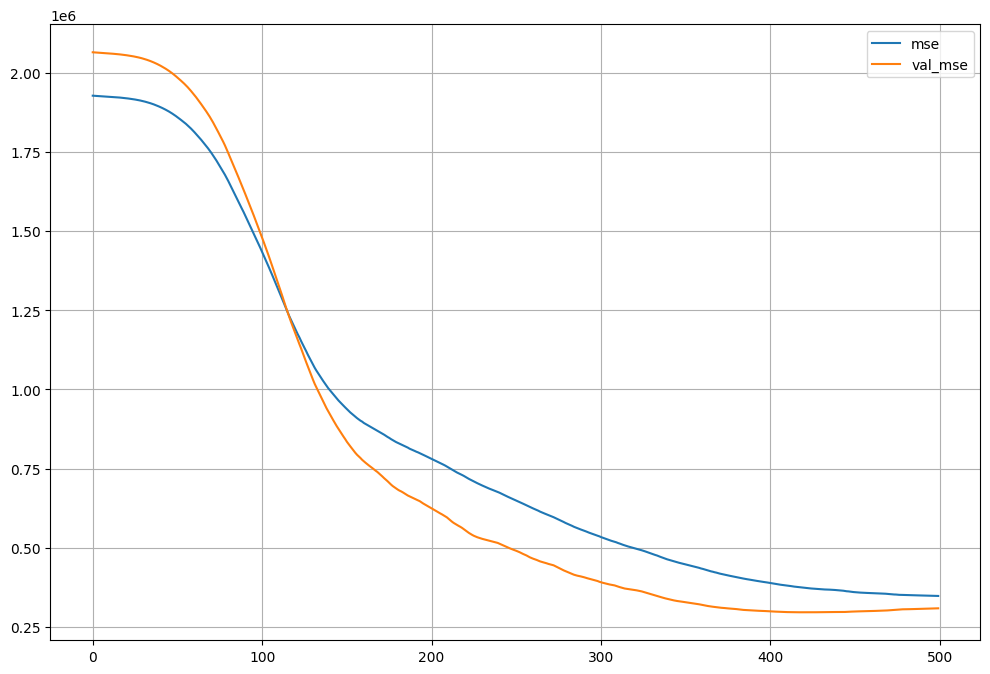

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
# 훈련 데이터의 mse
plt.plot(history.history['mean_squared_error'])
# 검증 데이터의 mse
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['mse','val_mse'])
plt.grid()
plt.show()

In [19]:
# 훈련 결과 중 마지막 5개를 확인

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mean_squared_error,mean_absolute_error,val_loss,val_mean_squared_error,val_mean_absolute_error,epoch
495,348717.68750,348717.68750,413.918121,308489.09375,308489.09375,471.932648,495
496,348598.53125,348598.53125,413.989014,308662.06250,308662.06250,472.187134,496
497,348456.15625,348456.15625,413.868744,308835.25000,308835.25000,472.162964,497
498,348322.78125,348322.78125,413.772644,309059.25000,309059.25000,472.307526,498
499,348167.75000,348167.75000,413.667755,309128.53125,309128.53125,471.983276,499


# 재학습

In [20]:
# 모델 저장
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("linear_keras_sellout.h5")

# 모델 불러오기
from tensorflow.keras.models import model_from_json 
json_file = open("model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("linear_keras_sellout.h5") 

# 모델 재 컴파일
loaded_model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_absolute_error', 'mean_squared_error'])


loaded_model.summary()

# 모델 재 학습
early_stopping_monitor = EarlyStopping(patience=50)
EPOCHS = 100

#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
history =loaded_model.fit(trainingData_features,
                   trainingData_label, 
                   validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 1s 148ms/step - loss: 348432.2188 - mean_absolute_error: 414.0217 - mean_squared_error: 348432.2188 - val_loss: 309649.5000 - val_mean_absolute_error: 473.1929 - val_mean_squared_error: 309649.5000
Epoch 2/100
3/3 [==============================] - 0s 31ms/step - los

# 6. 모델 추론

In [21]:
import numpy as np
# loss, mae, rmse 결과 확인
loss, mae, mse = model.evaluate(x=testData_features , 
                                y=testData_label, verbose=0)
# mae 및 mse 결과 확인
mae

mse = np.sqrt(mse)
mse

22.79892977160263

# 7. 모델 예측

In [22]:
# 예측 수행
test_predictions = model.predict(testData_features).flatten()
test_predictions

# 예측결과 별도 데이터프레임 생성
predictValues = pd.DataFrame(test_predictions, columns=["PREDICT"])

testData_label.reset_index(drop=True, inplace=True)

# 예측결과 컬럼 생성
finalResult = pd.concat([testData_label,predictValues],axis=1)
finalResult

1/1 [==============================] - 0s 94ms/step


,QTY,PREDICT
0,43,394.253235
1,1700,1797.542236
2,1514,1797.542236
3,1501,1797.542236
4,1491,1082.281494
5,806,1082.281494
6,2111,1065.478394
7,2400,1065.478394
8,2010,1758.942139
9,1900,1065.478394


# 8. 예측결과 비교 (시각화)

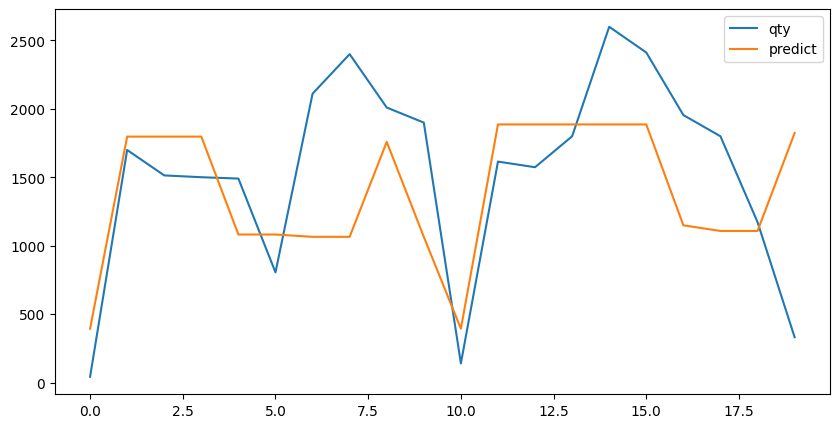

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(finalResult.QTY, label = "qty")
plt.plot(finalResult.PREDICT, label = "predict")
plt.legend(loc=0)